In [47]:
import numpy as np
import torch
import learn2learn as l2l

from torch import nn, optim
from Task_generation.Polynomial3D import Polynomial3D

import matplotlib.pyplot as plt
if torch.cuda.is_available():  
  dev = "cuda:1" 
else:  
  dev = "cpu"

from siren_pytorch import SirenNet

from numpy.polynomial.chebyshev import chebval3d
from adapters import fast_adapt_heat
from numerical_solvers import HeatSolver

# Generate data, task and non task specific

In [48]:
shots = 20
num_tasks = 1000
test_sources = Polynomial3D(num_samples_per_task=2*shots, degree=5, cube_range =[[0,1],[0,1],[0,0]], num_tasks=num_tasks)

t = torch.linspace(0,1,shots)
x = torch.linspace(0,1,shots)
residue = torch.cartesian_prod(x,t).to(dev)
# u(0,t) = 0 = g1(x,t)
x_0 = torch.zeros(1)
g_1 = torch.zeros(1).to(dev)
input_bc_1 = torch.cartesian_prod(x_0,t).to(dev)
# u(1,t) = 0 = g2(x,t)
x_1 = torch.ones(1)
g_2 = torch.zeros(1).to(dev)
input_bc_2 = torch.cartesian_prod(x_1,t).to(dev)

boundary = [torch.cat([input_bc_1,input_bc_2]),torch.zeros((torch.cat([input_bc_1,input_bc_2]).shape[0],1)).to(dev)]

# Load the model and the relevant hyperparameters

In [65]:
checkpoint = torch.load('./models/heat.pth')
adaptation_steps = checkpoint['steps']
model = SirenNet(
    dim_in = 2,                        # input dimension, ex. 2d coor
    dim_hidden = 128,                  # hidden dimension
    dim_out = 1,                       # output dimension, ex. rgb value
    num_layers = 3,                    # number of layers
    final_activation = nn.Identity(),   # activation of final layer (nn.Identity() for direct output)
    w0_initial = 3.                   # different signals may require different omega_0 in the first layer - this is a hyperparameter
).to(dev)

model.load_state_dict(checkpoint['net'])
opt_state = checkpoint['opt']
weights = (1,1)

In [77]:
checkpoint = torch.load('./models/heat2.pth')
adaptation_steps = checkpoint['steps']
model = SirenNet(
    dim_in = 2,                        # input dimension, ex. 2d coor
    dim_hidden = 64,                  # hidden dimension
    dim_out = 1,                       # output dimension, ex. rgb value
    num_layers = 2,                    # number of layers
    final_activation = nn.Identity(),   # activation of final layer (nn.Identity() for direct output)
    w0_initial = 3.                   # different signals may require different omega_0 in the first layer - this is a hyperparameter
).to(dev)

model.load_state_dict(checkpoint['net'])
opt_state = checkpoint['opt']
weights = (1,1)

# Plot training curves

# Evaluate model on test tasks

In [79]:
errors = []
x_r = torch.linspace(0,1,40).reshape(-1,1)
x = torch.cartesian_prod(torch.linspace(0,1,20),torch.zeros(1))

for i in test_sources:
    poly = i.coefficients
    
    f_r = lambda x: chebval3d(x,np.zeros(x.shape),np.zeros(x.shape),poly)*np.sin(x*np.pi)
    u_true, t_r= HeatSolver(f_r, x_r.numpy(), t_max=1, alpha=0.1)
    f = chebval3d(x[:,0],np.zeros(x[:,0].shape),np.zeros(x[:,0].shape),poly)
    task = [x.numpy(),f]


    model.load_state_dict(checkpoint['net'])
    adapt_opt = torch.optim.SGD(
                model.parameters(),
                lr=0.001)
    evaluation_loss,_,adapted_state = fast_adapt_heat(task,
                                boundary,
                                model,
                                adapt_opt,
                                adaptation_steps,
                                weights,
                                dev,
                                residue)
    model.load_state_dict(adapted_state)
    u_pred = model(torch.cartesian_prod(x_r.flatten(),torch.from_numpy(t_r).float()).to(dev)).cpu().detach().numpy()


    u_pred = u_pred.reshape(u_true[0].shape)
    
    errors.append(np.abs(u_true-u_pred).mean())
print(sum(errors)/1000)

0.032052943013942


# Plot results for a specific sampled task

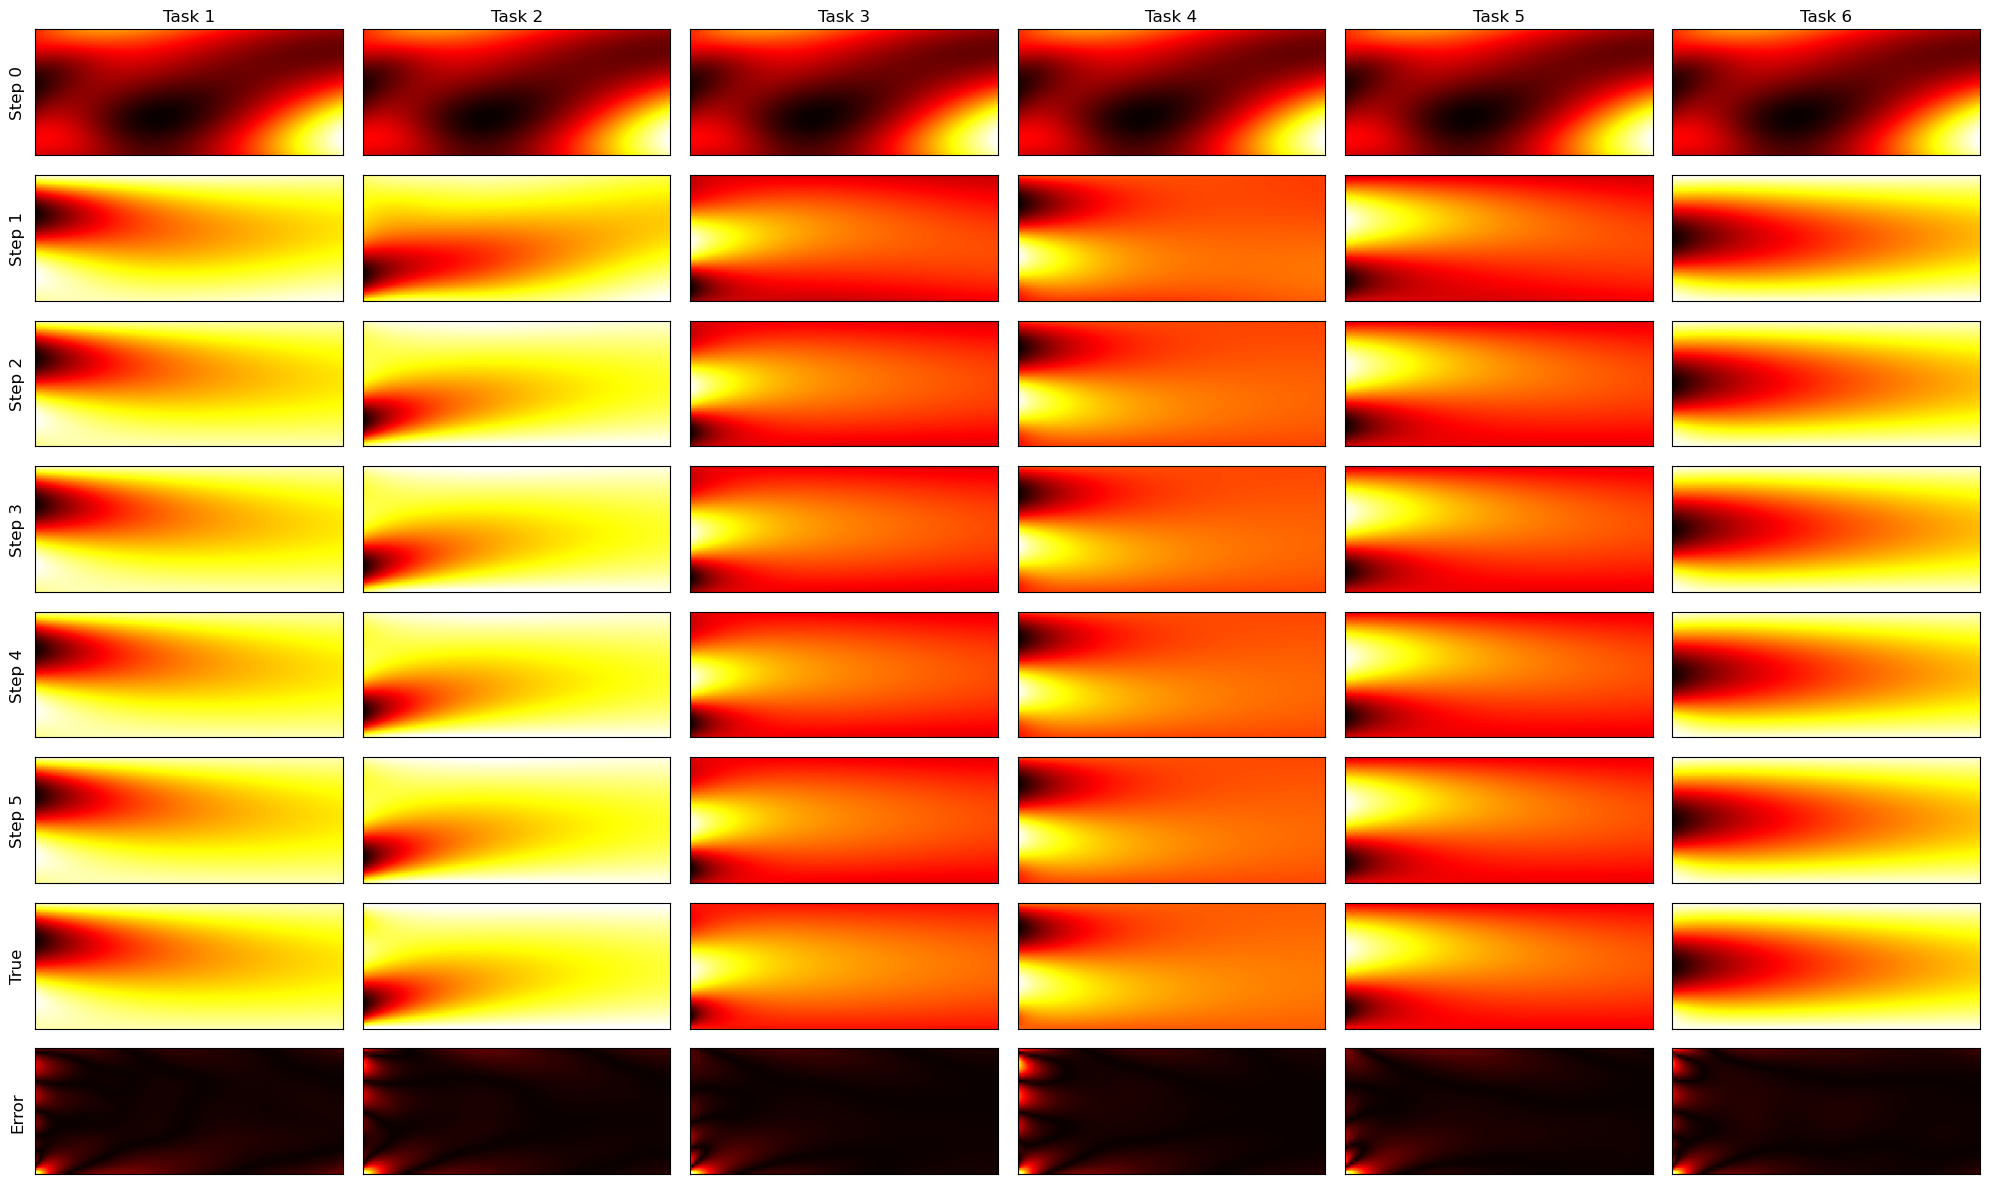

In [76]:
import matplotlib as mpl
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["c", "r", "k"]) 
x_r = torch.linspace(0,1,40).reshape(-1,1)
fig, ax = plt.subplots(8, 6, figsize = (20,12))
cols = ['Task {}'.format(col) for col in range(1, 7)]
rows = ['Step {}'.format(row) if row<6 else 'True' for row in range(0,7)]+['Error']


for axis, col in zip(ax[0], cols):
    axis.set_title(col)

for axis, row in zip(ax[:,0], rows):
    axis.set_ylabel(row, rotation=90, size='large')


for axis in ax.flatten():
    axis.set_xticks([])
    axis.set_yticks([])

for j in range(6):
    model.load_state_dict(checkpoint['net'])
    adapt_opt = torch.optim.SGD(
                model.parameters(),
                lr=0.001)
    adapt_opt.load_state_dict(opt_state)
    
    poly = test_sources.sample_task()
    f_r = lambda x: chebval3d(x,np.zeros(x.shape),np.zeros(x.shape),poly.coefficients)*np.sin(x*np.pi)
    u_true, t_r= HeatSolver(f_r, x_r.numpy(), t_max=1, alpha=0.1)


    x = torch.cartesian_prod(torch.linspace(0,1,20),torch.zeros(1))
    f = chebval3d(x[:,0],np.zeros(x[:,0].shape),np.zeros(x[:,0].shape),poly.coefficients)
    task = [x.numpy(),f]

    for i in range(adaptation_steps):
        u_pred = model(torch.cartesian_prod(x_r.flatten(),torch.from_numpy(t_r).float()).to(dev)).cpu().detach().numpy()
        u_pred = u_pred.reshape(u_true[0].shape)
        ax[i,j].imshow(u_pred, aspect='auto', cmap = 'hot')

        evaluation_loss,_,adapted_state = fast_adapt_heat(task,
                                boundary,
                                model,
                                adapt_opt,
                                1,
                                weights,
                                dev,
                                residue)
        model.load_state_dict(adapted_state)
    u_pred = model(torch.cartesian_prod(x_r.flatten(),torch.from_numpy(t_r).float()).to(dev)).cpu().detach().numpy()
    u_pred = u_pred.reshape(u_true[0].shape)
    ax[i+1,j].imshow(u_pred, aspect='auto', cmap = 'hot')
    ax[i+2,j].imshow(u_true[0], aspect='auto', cmap = 'hot')
    ax[i+3,j].imshow(np.abs(u_true[0]-u_pred), aspect='auto', cmap = 'hot')
    

plt.tight_layout()
